### Task 2: Exploratory Data Analysis (EDA)

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int6

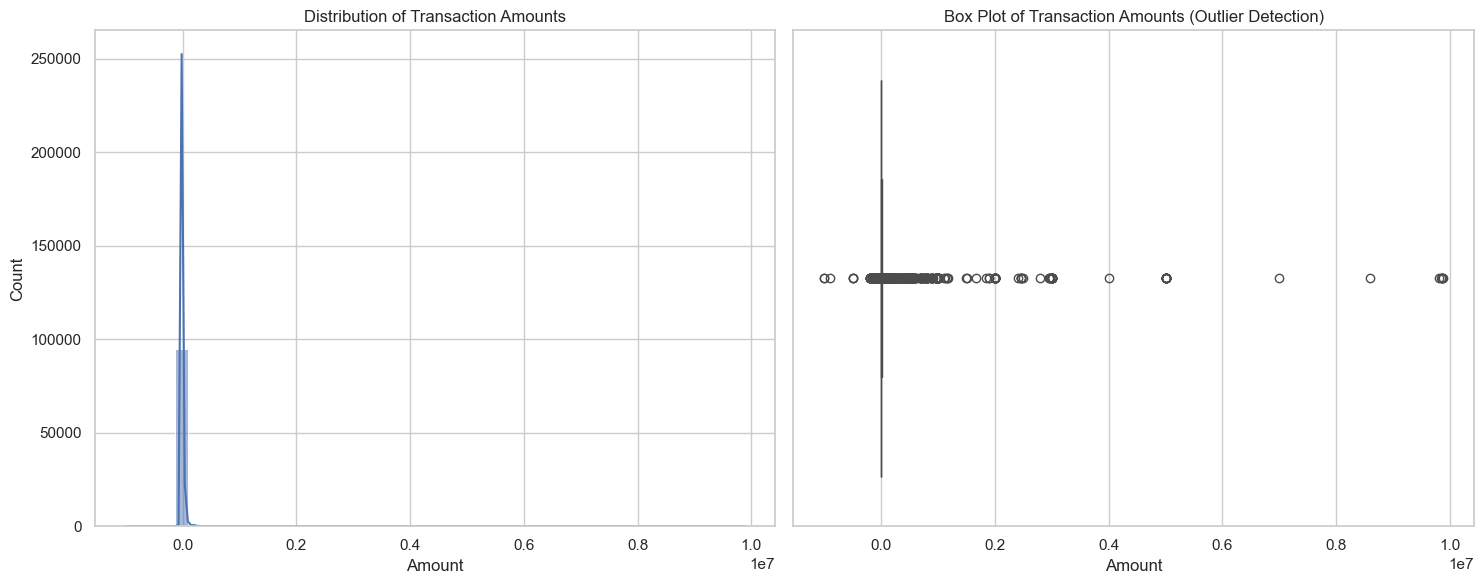


Number of amount outliers: 24441 (25.55%)

Fraud rate: 0.20%
Fraud rate in outliers: 0.78%


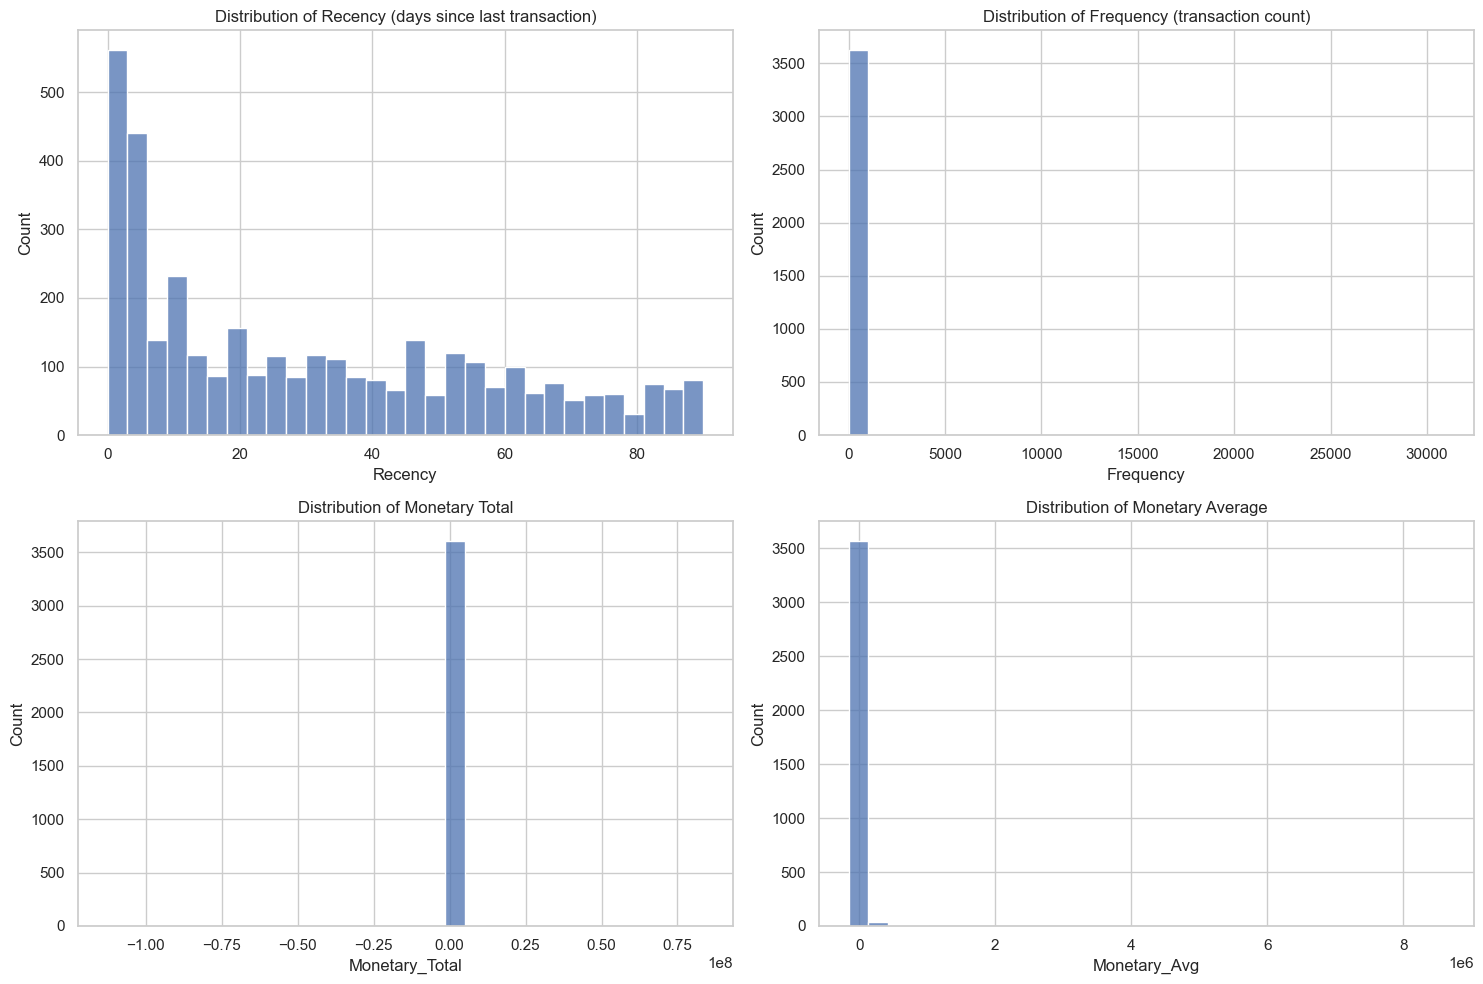

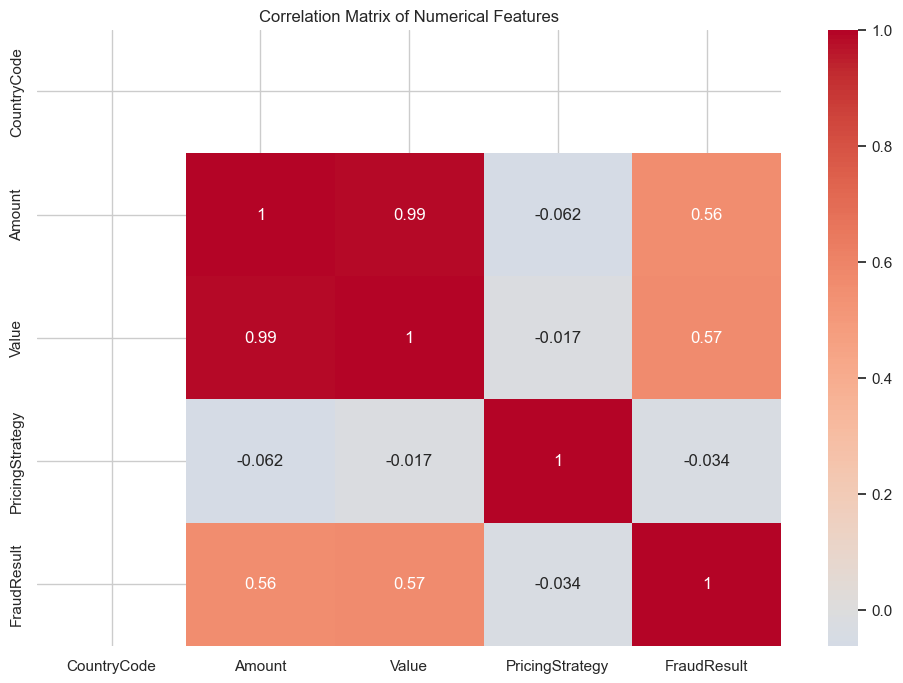


=== RFM Outliers ===
Recency: 0 outliers (0.00%)
Frequency: 421 outliers (11.59%)
Monetary_Total: 435 outliers (11.97%)
Monetary_Avg: 292 outliers (8.04%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('../data/raw/data.csv')

# 1. Initial Overview ==============================================
print("=== Dataset Information ===")
print(df.info())

print("\n=== Descriptive Statistics ===")
print(df.describe(include='all'))

print("\n=== Unique Value Counts ===")
print(df.nunique())

# 2. Data Quality Check ============================================
print("\n=== Missing Values ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 3. Transaction Amount Analysis ===================================
plt.figure(figsize=(15, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')

# Box plot for outlier detection
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Amount'])
plt.title('Box Plot of Transaction Amounts (Outlier Detection)')
plt.xlabel('Amount')

plt.tight_layout()
plt.show()

# Outlier quantification
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]
print(f"\nNumber of amount outliers: {len(outliers)} ({len(outliers)/len(df):.2%})")

# 4. Fraud Analysis ================================================
fraud_rate = df['FraudResult'].mean()
print(f"\nFraud rate: {fraud_rate:.2%}")

# Check if outliers correlate with fraud
fraud_in_outliers = outliers['FraudResult'].mean()
print(f"Fraud rate in outliers: {fraud_in_outliers:.2%}")

# 5. RFM Analysis (Potential Proxy Variable) =======================
# Convert to datetime if not already
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate RFM metrics
rfm = df.groupby('AccountId').agg({
    'TransactionStartTime': lambda x: (df['TransactionStartTime'].max() - x.max()).days,  # Recency
    'TransactionId': 'count',  # Frequency
    'Amount': ['sum', 'mean']  # Monetary (total and average)
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary_Total', 'Monetary_Avg']

# Plot RFM distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Recency
sns.histplot(rfm['Recency'], bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Recency (days since last transaction)')

# Frequency
sns.histplot(rfm['Frequency'], bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Frequency (transaction count)')

# Monetary Total
sns.histplot(rfm['Monetary_Total'], bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Monetary Total')

# Monetary Average
sns.histplot(rfm['Monetary_Avg'], bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Monetary Average')

plt.tight_layout()
plt.show()

# 6. Correlation Analysis ==========================================
numerical_df = df.select_dtypes(include=[np.number])

# Exclude non-relevant numerical columns (like IDs)
if 'TransactionId' in numerical_df.columns:
    numerical_df = numerical_df.drop(columns=['TransactionId', 'BatchId', 'AccountId', 
                                             'SubscriptionId', 'CustomerId'], errors='ignore')

plt.figure(figsize=(12, 8))
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Additional Outlier Analysis ======================================
# Check for outliers in RFM metrics
rfm_outliers = {}
for col in rfm.columns:
    Q1 = rfm[col].quantile(0.25)
    Q3 = rfm[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_count = len(rfm[(rfm[col] < lower) | (rfm[col] > upper)])
    rfm_outliers[col] = outliers_count

print("\n=== RFM Outliers ===")
for metric, count in rfm_outliers.items():
    print(f"{metric}: {count} outliers ({count/len(rfm):.2%})")